# **ETC3250 Project Report**
### <u>Team Members</u>


*   26927462 Phadon Phipat
*   27103013 Kwan King Yung
*   29730163 Thomas Hughes
*   28791789 Kavisan Thavarajah



#Introduction
This project aims to effectively develop a model of supervised learning which is able to effectively predict hand-drawn drawing into 6 classes which are “banana”, “boomerang”, “cactus”, “crab”, “flip flops” and “kangaroo”.  A training set and test set containing different drawing of each class has been provided, the prediction model has been developed and derived using these inputs as the only source. 

#CNN Model
The Convolutional Neural Network (CNN) has been chosen as the model to undertake the requirements of this project. Similar to many neural network models covered in the unit, the CNN processes the input through several hidden layers and an output is derived using an activation function. The main difference of the CNN to other neural networks is that this network models possesses a convolutional layer.  

###Convolution Layers
In the convolutional layers different filters (kernels) are applied to the input images to understand the various features of an image. Filters can be used to assist in understand aspects of an image such as identifying edges, they also assist in preforming operations such as sharpening or blurring the image. Each filter(kernel) assists the model in understands and learning more about the input image and the relationships between certain pixels within the input image.

Parameters for these convolutional layers also need to be chosen for the effectiveness and efficiency of the network. Common parameters include strides and padding.

•	Strides – Number of pixels to shift over in the input before a filter is applied again to the input

•	Padding – When filter does not fit perfectly with the input. The input can be padded with zeroes or parts of the image can be dropped where filter cannot be applied.

Source: https://medium.com/@RaghavPrabhu/understanding-of-convolutional-neural-network-cnn-deep-learning-99760835f148



In [0]:
#@title
import pandas as pd
import multiprocessing
import numpy as np
import random
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import StepLR

import sys
import os
from google.colab import drive
from IPython.display import clear_output

In [3]:
!pip3 install graphviz
!pip install hiddenlayer

import hiddenlayer as hl

In [0]:
#@title
sketchesTrainDf = pd.read_csv("sketches_train.csv")
sketchesTrain = sketchesTrainDf.drop(["word","id",sketchesTrainDf.columns[0]], axis = 1).to_numpy()

sketchesTrain = sketchesTrain.reshape(-1, 28, 28)

## <u>Data Exploration</u>

It is extremely important to train with a balanced dataset as machine learning classifiers are sensitive to the proportions of the dataset. This is because in imbalanced datasets, these classifiers tend to favour the class with the largest number of observations which may lead to misleading accuracies. 

For example, consider a dataset with two distinct classes, where one consists of 95% of the dataset and the other class consists of the remaing 5%. A model that predicts the majority class everytime would yield an accuracy of 95%. Clearly this is deceiving and not the desired behaviour.

In the pictionary training dataset, it can be seen that the dataset is perfectly balanced between the 6 classes. There are 1000 images in each class giving a total of 6000 images. We therefore do not have to worry about working with an unbalanced dataset.

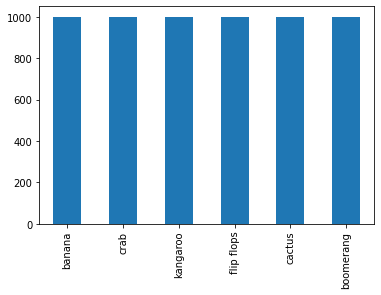

In [5]:
#@title
labelNames = sketchesTrainDf["word"].tolist()

label = {"boomerang": 0,
          "banana": 1,
         "cactus": 2,
         "kangaroo": 3,
         "crab": 4,
         "flip flops":5
         }

labels = torch.tensor([label[lblName] for lblName in labelNames])

sketchesTrainDf["word"].value_counts().plot.bar();

During data exploration it is also very useful to have a look at the images in the dataset. A random selection of 16 images is shown below.

Unfortunately, many of the drawings are of poor quality and would be difficult even for a human to predict. Some images are black boxes which is nonsense.

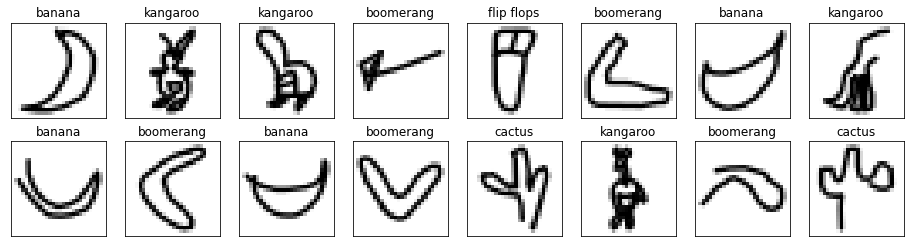

In [6]:
#@title 
plt.figure(figsize = (16,4))

for i in range(16):
    randIdx = random.randint(0, 6000)

    plt.subplot(2,8,i+1)
    plt.title(labelNames[randIdx],fontsize=12) # + " " + str(randIdx))
    plt.imshow(sketchesTrain[randIdx], cmap='gray_r', vmin=0, vmax=255)
    
    ax = plt.gca()
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)

The entire 6000 images were looked over for any outlier images. As can be seen below, these images include scribbles, black boxes and text of the words instead of drawings. Some images are of different objects altogether. For example, there is a lollipop that is labelled as flip flops.

Training was done including and not including these images. It was found that leaving these images in resulted in a higher final total accuracy of approximately 1%. It can be speculated the network somehow managed to find patterns in these images to help it predict on the test set even though we couldn't see any ourselves.

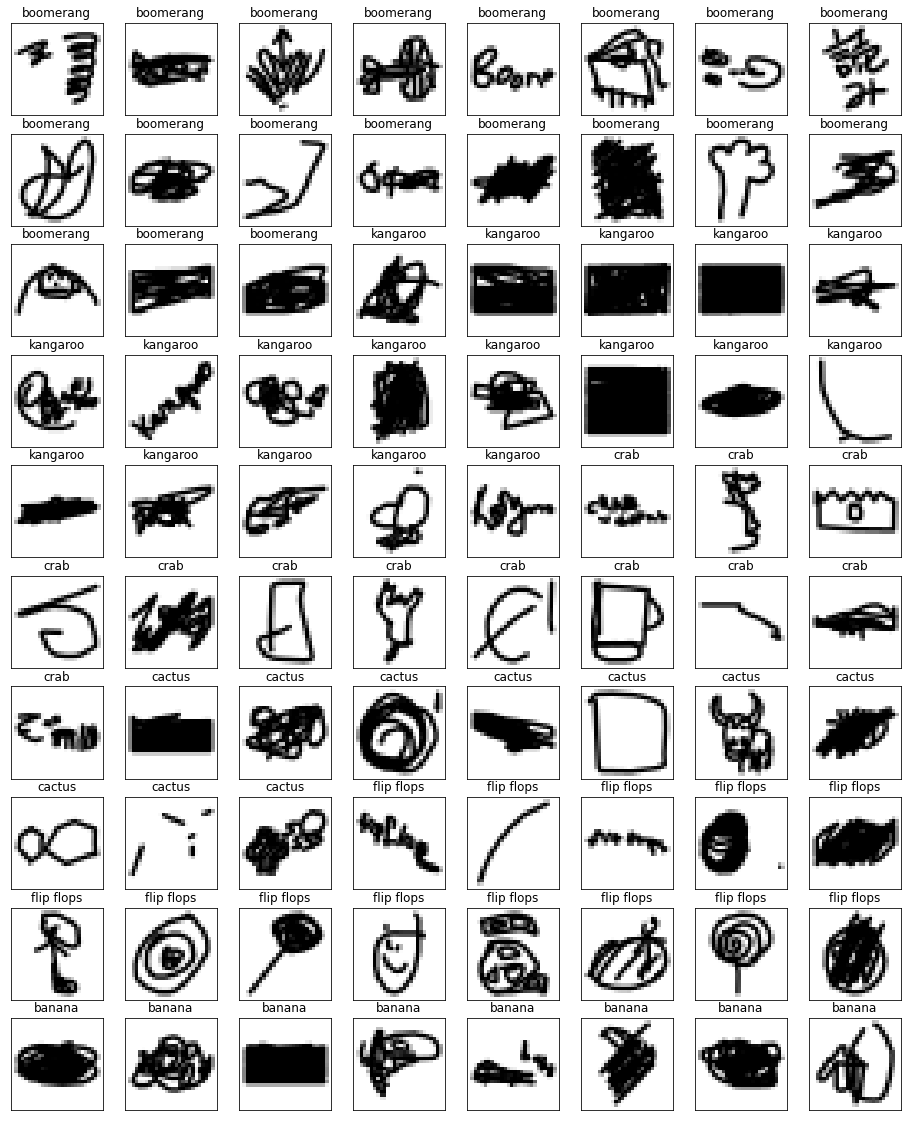

In [7]:
badBoomerangIdx = [23,30,31,59,126,210,239,243,294,404,434,495,504,522,545,564,625,698,902]
badKangarooIdx = [1016,1042,1081,1107,1129,1137,1169,1270,1302,1466,1477,1546,1659,1761,1828,1860,1957,1995]
badCrabIdx = [2220,2284,2307,2389,2449,2477,2481,2505,2534,2616,2859,2964]
badCactusIdx = [3023,3128,3299,3325,3339,3401,3442,3494,3511,3634]
badFlipFlopsIdx = [4029,4077,4161,4171,4273,4359,4366,4538,4552,4641,4659,4800,4983]
badBananaIdx = [5482,5512,5541,5597,5613,5777,5873,5928]

plt.figure(figsize = (16,20))
badIdx = badBoomerangIdx + badKangarooIdx + badCrabIdx + badCactusIdx + badFlipFlopsIdx + badBananaIdx
for plotIdx, i in enumerate(badIdx):
    plt.subplot(10,8,plotIdx+1)
    plt.title(labelNames[i],fontsize=12) # + " " + str(randIdx))
    plt.imshow(sketchesTrain[i], cmap='gray_r', vmin=0, vmax=255)
    
    ax = plt.gca()
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)

In [0]:
#@title
class SketchesData(Dataset):
  def __init__(self, images, labels, transform=None):
    self.images = images
    self.labels = labels
    self.transform = transform

  def __len__(self):
    return len(self.images)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
          idx = idx.tolist()

    sample = self.images[idx,:]
    labels = self.labels[idx]
    if self.transform:
      sample = self.transform(sample)
    else:
      sample = transforms.Compose([
            transforms.ToPILImage(),transforms.ToTensor()])(sample)
      
    return sample, labels

#**Methodology**

The task at hand was to build an image classifier that could classify images into 6 distinct classes. In recent years, the clear winner out of the machine learning algorithms are deep learning approaches, in particular using a convolutional neural network.

##<u>Deep Learning</u>

Deep learning is a subset of machine learning in which neural networks are trained to receive input data and make a prediction based on that data. Neural networks are based on the human brain and are built from many neurons which are arranged in layers from the input layer to the output layer.

In the simplest type of neural network, the fully connected neural network or multi-layer perceptron (MLP) all the neurons from one layer connect to all the neurons in the next layer. These neurons in the next layer receive the outputs of the neurons from the previous layer as its input. The dot product between this input vector and a weight vector added with a bias is the output of the neuron (after an activation function is added).  

It is the weight vector that each neuron in an neural network possesses that are tuned during training. 

A neural network that possesses a single hidden layer is sufficient to approximate any function. It is this ability for a neural network to be a universal function approximator that makes a neural network so powerful.

<br><br><br>

![Neural Network](https://www.researchgate.net/profile/Facundo_Bre/publication/321259051/figure/fig1/AS:614329250496529@1523478915726/Artificial-neural-network-architecture-ANN-i-h-1-h-2-h-n-o.png)


##<u>Convolutional Neural Networks</u>

Convolutional neural networks are a class of neural networks that are particularly suited for image recognition.

One of the problems with a simple fully connected neural network with image recognition is due to its fully connected nature, connections between pixels far away from each other in the image are given the same importance as connections between pixels close together. Although the neural network can learn to subdue these connections this spatial structure is left unexploited. MLPs also can end up having a huge number of connections between neurons, especially if the image is of high resolution.

##TO DO explain why convolutional neural networks are good and explain how they work


##<u>Overfitting</u>

The main concern during the training of the network is overfitting. Overfitting is where the classifier starts to model the small random variations in the training set. This hinders the network's ability to generalize to unseen images and can reduce its accuracy.

Unfortunately, neural networks are highly prone to overfitting, unless the number of observations in the training set is extremely large. Therefore, much care must be placed in ensuring overfitting is minimized. 

### Strategies to prevent Overfitting

TO DO EXPLAIN THESE

*   Network Architecture, simpler models tend to overfit more
*   Data augmentation

Data Augmentation is a strategy that helps significantly increase of data without collecting any new data. Common techniques involve cropping, padding and flipping. 

Augmentation Techniques used in the chosen model are:

o	Rotations – Input images are randomly rotated by angles up to 15 degrees

o	Affine Transformation – random transformations, but collinearity and ratios of distances remain the same. 
Affine rotations have been disabled and translations 
of up to 10% are occurring.

o	Cropping – Images are cropped randomly up to 10%. 

o	Horizontal Flipping – 50% of the images are flipped horizontally. 

These techniques provide the model with image variations that enables the network to learn further important features from the current dataset which provides limited quantity and diversity and significantly reduces overfitting. 


*   Splitting into training, validation and test to check whether overfitting
*   Batch Normalization

Batch Normalisation is a process in which the output of an activation layer is normalised by standardising the output based on batch mean and standard deviation. The exact reasons for why batch normalisation works is still relatively unknown. However is speculated that this enables greater stability of the neural network and would also likely speed up the training process. This is because the input layer benefits because all input features will have a small range as a result of the standardisation. 

*   Drop out

The dropout is another regularisation method used to reduce overfitting in neural networks. Models such as this with large neural networks and small datasets can overfit the training data very easily. 

During the training of the model, some neurons are randomly temporarily removed. 

As a neural network learns, neuron weights settle into their context within the network. Weights of neurons are tuned for specific features providing some specialization. Neighboring neurons become to rely on this specialization, which if taken too far can result in a fragile model too specialized to the training data. This reliant on context for a neuron during training is referred to complex co-adaptations.

You can imagine that if neurons are randomly dropped out of the network during training, that other neurons will have to step in and handle the representation required to make predictions for the missing neurons. This is believed to result in multiple independent internal representations being learned by the network.

The effect is that the network becomes less sensitive to the specific weights of neurons. This in turn results in a network that is capable of better generalization and is less likely to overfit the training data.

Dropout rate values range from 0 to 1. 1 is for no dropouts and 0 is for no inputs. In common practice dropout rates range between 0.5 to 0.8. Using batch normalisation in the model allows the use of a lower dropout rate and as such 0.5 has been chosen. 

https://machinelearningmastery.com/dropout-regularization-deep-learning-models-keras/

*   Learning rate choice

Learning rate is the parameter which chooses how quickly a model learns the model. It is also referred to as step size and is the rate which determines the amount that “the apportioned error that the weights of the model are updated with each time they are updated.”

Higher learning rates will enable a model to learn faster but may risk the possibility of a lower quality final set of weights. A smaller learning will produce an optimal set of weights but the model will take longer to train. 

During training, the learning rate is typically lowered after a certain number of epochs. This allows the model to quickly train towards a general optimal region, and for the lower learning rate to be used to refine the final set of weights. 

After trial and error, the learning rate used in the final model was 0.001, which was dropped to 0.0001 after 200 epochs. The model trained for 250 epochs.

Source: https://machinelearningmastery.com/learning-rate-for-deep-learning-neural-networks/

*   Early Stopping, don't train for too long

When training neural networks it is important to assess how long to train the model. When training is kept to a minimum this will likely underfit the model. Training the model for too long will result in the network overfitting the training set.

Early Stopping occurs when the training of the model is stopped when the validation dataset performance begins to diminish. This can be assessed from the Net Loss and Net Accuracy graphs provided in this report. Both these reports suggest the Validation set performance begins to diminish when x = 25(not sure what x represents). Hence, this should be used as the Early stopping to ensure that the model is not overfitted, but still contains enough information for efficient performance on the test set. 

Source: https://machinelearningmastery.com/early-stopping-to-avoid-overtraining-neural-network-models/  


*   Might try ensembling networks

*   l2 regularization
L2 Regularization is a regularisation technique in which the size of the weights is added to the loss function, thereby punishing models with large weights. Intuitively, simpler models are less likely to overfit. Therefore by encouraging the model to use small weights, overfitting is reduced. A parameter of 0.0001 was chosen for the weight decay. This is quite a small number and in practice, l2 regularization was not found to be too helpful, however it was left in as it did not seem to lower the accuracy.




In [0]:
transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomRotation(15),
            transforms.RandomAffine(0, (0.1,0.1)),
            transforms.RandomResizedCrop((28,28),(0.9,1)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.ToTensor(),
]) 


In [0]:
# sketchesTrain = np.delete(sketchesTrain, badIdx, axis=0)
# labels = np.delete(labels, badIdx, axis=0)

In [11]:
#@title

def createDataSets(trainSplit, valSplit, testSplit):
    batchSize = 64

    trainIdx = np.random.choice(6000, trainSplit, replace=False)
    valTestIdx = np.delete(np.arange(0, 6000), trainIdx)
    trainSet = SketchesData(torch.tensor(sketchesTrain, dtype=torch.uint8)[trainIdx], torch.tensor(labels, dtype=torch.uint8)[trainIdx], transform)
    trainNonTransformSet = SketchesData(torch.tensor(sketchesTrain, dtype=torch.uint8)[trainIdx], torch.tensor(labels, dtype=torch.uint8)[trainIdx], None)
    valTestSet = SketchesData(torch.tensor(sketchesTrain, dtype=torch.uint8)[valTestIdx], torch.tensor(labels, dtype=torch.uint8)[valTestIdx], None)
    valSet, testSet = torch.utils.data.random_split(valTestSet, [valSplit, testSplit])

    n_workers = multiprocessing.cpu_count()
    trainLoader = torch.utils.data.DataLoader(trainSet, batch_size=batchSize,
                                            shuffle=True, num_workers=n_workers)
    trainNonTransformLoader = torch.utils.data.DataLoader(trainNonTransformSet, batch_size=batchSize,
                                            shuffle=False, num_workers=n_workers)
    valLoader = torch.utils.data.DataLoader(valSet, batch_size=batchSize,
                                            shuffle=False, num_workers=n_workers)
    testLoader = torch.utils.data.DataLoader(testSet, batch_size=batchSize,
                                            shuffle=False, num_workers=n_workers)
    return trainLoader, trainNonTransformLoader, valLoader, testLoader

trainLoader, trainNonTransformLoader, valLoader, testLoader = createDataSets(5400,600,0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.


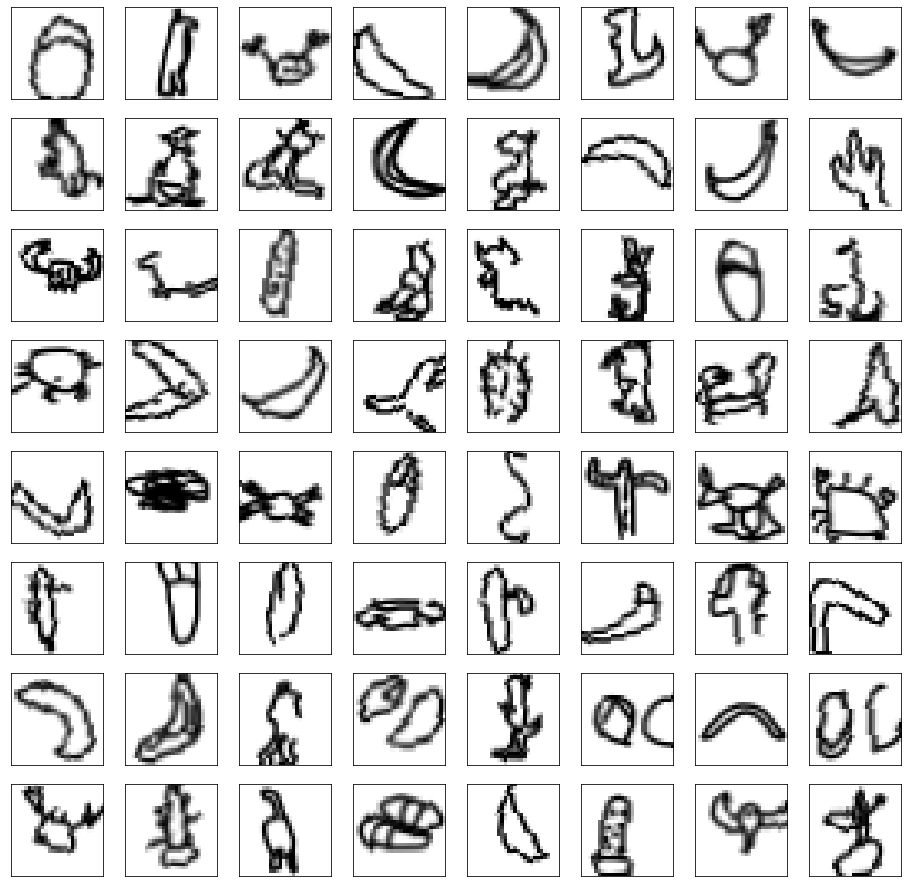

In [12]:
image_batch, _ = next(iter(trainLoader))
plt.figure(figsize = (16,16))
for i, image in enumerate(image_batch):    
    plt.subplot(8,8,i+1)
    plt.imshow(image.squeeze(0), cmap='gray_r', vmin=0, vmax=1)

    ax = plt.gca()
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)

In [0]:
#How many itterations of our dataset
num_epochs = 150
#optimizer learning rate
learning_rate  = 0.001
weight_decay = 1e-4
learning_rate_decay = 0.1
lr_gamma = 100
#initialise what epoch we start from
start_epoch    = 0
#initialise best valid accuracy 
best_valid_acc = 0

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')

In [0]:
training_loss_logger = []
training_acc_logger = []
validation_loss_logger = []
validation_acc_logger = []
training_non_transform_loss_logger = []
training_non_transform_acc_logger = []

In [0]:
class CNN(nn.Module):
    def __init__(self, dropout, numClasses = 6):
        super(CNN, self).__init__()
        self.dropout = dropout
        self.conv1 = nn.Conv2d(1, 64, kernel_size=5)
        self.batch1 = nn.BatchNorm2d(64)
        
        self.conv2 = nn.Conv2d(64, 128, kernel_size=5)
        self.batch2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128,256, kernel_size=5)
        self.batch3 = nn.BatchNorm2d(256)

        self.fc1 = nn.Linear(3*3*256, 256)
        self.batch4 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, numClasses)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.batch1(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = self.batch2(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(F.max_pool2d(self.conv3(x),2))
        x = self.batch3(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = x.view(-1,3*3*256)
        x = F.relu(self.fc1(x))
        x = self.batch4(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.fc2(x)

        return F.log_softmax(x, dim=1)
 


In [17]:
dropout = 0.5
net = CNN(dropout).to(device)
print(net)

CNN(
  (conv1): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1))
  (batch1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (batch2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1))
  (batch3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=2304, out_features=256, bias=True)
  (batch4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=256, out_features=6, bias=True)
)


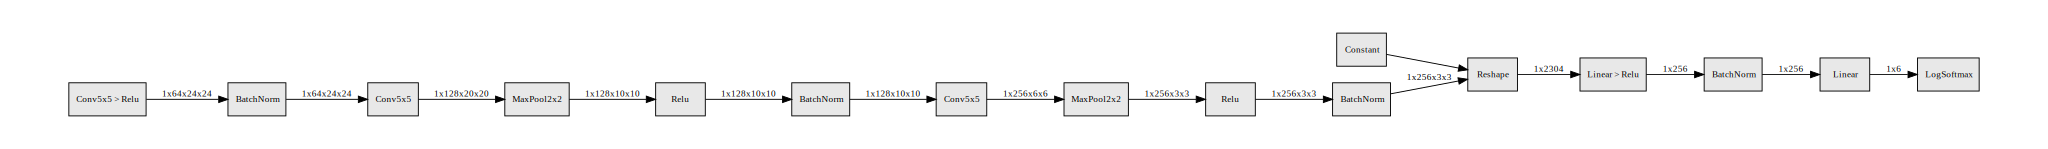

In [18]:
#create a dataloader itterable object
dataiter = iter(valLoader)
#sample from the itterable object
images, _ = dataiter.next()

#pass image through network
#check output
net.eval()
hl.build_graph(net, images[0].unsqueeze(0).to(device))

In [0]:
#Pass our network parameters to the optimiser set our lr as the learning_rate

Loss_fun = nn.CrossEntropyLoss()

In [0]:
def calculate_accuracy(fx, y):
    preds = fx.max(1, keepdim=True)[1]
    correct = preds.eq(y.view_as(preds)).sum()
    acc = correct.float()/preds.shape[0]

    return acc

In [0]:
def trainEpoch(net, device, loader, optimizer, Loss_fun, epoch):
    
    #initialise counters
    epoch_loss = 0
    epoch_acc = 0
    
    #Set Network in train mode
    net.train()
    
    for i, (x, y) in enumerate(loader):
        
        #load images and labels to device
        x = x.to(device) # x is the image
        y = y.long().to(device) # y is the corresponding label
                
        #Forward pass of image through network and get output
        fx = net(x)

        #Calculate loss using loss function
        loss = Loss_fun(fx, y)
        
        #calculate the accuracy
        acc = calculate_accuracy(fx, y)

        #Zero Gradents
        optimizer.zero_grad()
        #Backpropagate Gradents
        loss.backward()
        #Do a single optimization step
        optimizer.step()
        
        #create the cumulative sum of the loss and acc
        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(loader), epoch_acc / len(loader)

In [0]:
def evaluate(net, device, loader, Loss_fun):
    
    epoch_loss = 0
    epoch_acc = 0

    net.eval()
    
    with torch.no_grad():
        for i, (x, y) in enumerate(loader):
            
            #load images and labels to device
            x = x.to(device)
            y = y.long().to(device)
            
            #Forward pass of image through network
            fx = net(x)
            #Calculate loss using loss function
            loss = Loss_fun(fx, y)

            #calculate the accuracy
            acc = calculate_accuracy(fx, y)
            
            #log the cumulative sum of the loss and acc
            epoch_loss += loss.item()
            epoch_acc += acc.item()
    
    #return the avaerage loss and acc from the epoch as well as the logger array  
    if len(loader) > 0:     
        return epoch_loss / len(loader), epoch_acc / len(loader)
    else:
        return 0, 0

In [0]:
def train(trainLoader, trainNonTransformLoader, validLoader, optimizer, scheduler, net, i):
    net.to(device)
    for epoch in range(start_epoch, num_epochs):

        train_loss, train_acc = trainEpoch(net, device, trainLoader, optimizer, Loss_fun, epoch)
        scheduler.step()

        train_non_transform_loss, train_non_transform_acc = evaluate(net, device, trainNonTransformLoader, Loss_fun)
        valid_loss, valid_acc = evaluate(net, device, validLoader, Loss_fun)

        clear_output(True)
        print(f"Network {i + 1} {'|'} Epoch: {epoch+1} {'|'} Train Loss: {train_loss:.2f}")
        print(f"Train Accuracy: {train_acc*100:.2f}% {'|'} Train Non Transform Accuracy: {train_non_transform_acc*100:.2f}% {'|'} Valid Accuracy: {valid_acc*100:.2f}%")

        training_loss_logger[i].append(train_loss)
        training_acc_logger[i].append(train_acc)
        validation_loss_logger[i].append(valid_loss)
        validation_acc_logger[i].append(valid_acc)
        training_non_transform_loss_logger[i].append(train_non_transform_loss)
        training_non_transform_acc_logger[i].append(train_non_transform_acc)

    net.cpu()
    return train_non_transform_loss, train_non_transform_acc, valid_loss, valid_acc

In [0]:
numNets = 10
nets = [CNN(dropout) for _ in range(numNets)]
netStatistics = []
training_loss_logger = [[] for _ in range(numNets)]
training_acc_logger = [[] for _ in range(numNets)]
validation_loss_logger = [[] for _ in range(numNets)]
validation_acc_logger = [[] for _ in range(numNets)]
training_non_transform_loss_logger = [[] for _ in range(numNets)]
training_non_transform_acc_logger = [[] for _ in range(numNets)]

for i, net in enumerate(nets):
    optimizer = optim.Adam(net.parameters(), lr = learning_rate, weight_decay=weight_decay)
    scheduler = StepLR(optimizer, step_size=lr_gamma, gamma=learning_rate_decay)

    trainLoader, trainNonTransformLoader, valLoader, testLoader = createDataSets(5400,600,0)
    train_non_transform_loss, train_non_transform_acc, valid_loss, valid_acc = train(trainLoader, trainNonTransformLoader, valLoader, optimizer, scheduler, net, i)
    netStatistics.append((train_non_transform_loss, train_non_transform_acc, valid_loss, valid_acc))

Network 10 | Epoch: 150 | Train Loss: 0.21
Train Accuracy: 92.76% | Train Non Transform Accuracy: 97.70% | Valid Accuracy: 91.88%


In [0]:
torch.save({"state_dicts": [net.state_dict() for net in nets],
            "statistics": netStatistics}, "nets.pt")

In [0]:
wholeTrainSet = sketchesTrain.reshape(-1, 1, 28, 28)/255
torch.cuda.empty_cache()
wholeTrainSet = torch.tensor(wholeTrainSet, dtype=torch.float32).cuda()

predictions = torch.zeros((6000,6))
with torch.no_grad():
    for net, netStats in zip(nets, netStatistics):
        trainLoss, trainAcc, validLoss, validAcc= netStats
        print(f"Train Loss {trainLoss:.2f} TrainAcc {trainAcc*100:.2f} Valid Loss {validLoss:.2f} Valid Acc {validAcc*100:.2f}")
        net.cuda()
        net.eval()
        netPredictions = net(wholeTrainSet).cpu()
        predictions += netPredictions
        torch.cuda.empty_cache()

print(f"Ensemble Accuracy: {calculate_accuracy(predictions, labels).item()*100:.2f}%")



Train Loss 0.07 TrainAcc 97.54 Valid Loss 0.17 Valid Acc 94.17
Train Loss 0.08 TrainAcc 97.47 Valid Loss 0.18 Valid Acc 93.75
Train Loss 0.08 TrainAcc 97.56 Valid Loss 0.20 Valid Acc 94.58
Train Loss 0.07 TrainAcc 97.65 Valid Loss 0.26 Valid Acc 91.82
Train Loss 0.08 TrainAcc 97.62 Valid Loss 0.20 Valid Acc 92.81
Train Loss 0.07 TrainAcc 97.78 Valid Loss 0.24 Valid Acc 92.60
Train Loss 0.07 TrainAcc 97.71 Valid Loss 0.16 Valid Acc 95.21
Train Loss 0.07 TrainAcc 97.68 Valid Loss 0.22 Valid Acc 94.17
Train Loss 0.07 TrainAcc 97.48 Valid Loss 0.21 Valid Acc 94.06
Train Loss 0.07 TrainAcc 97.70 Valid Loss 0.26 Valid Acc 91.88
Ensemble Accuracy: 97.47%


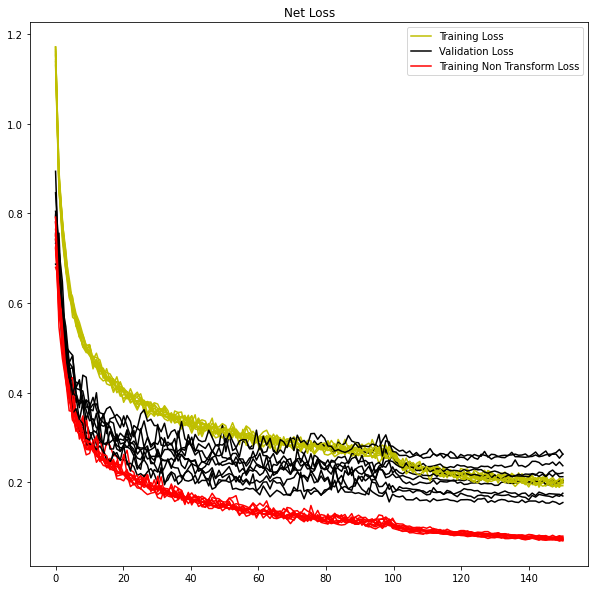

In [0]:
plt.figure(figsize = (10,10))

for i in range(numNets):
    train_x = np.linspace(0, num_epochs, len(training_loss_logger[i]))
    plt.plot(train_x, training_loss_logger[i], c = "y")
    valid_x = np.linspace(0, num_epochs, len(validation_loss_logger[i]))
    plt.plot(valid_x, validation_loss_logger[i], c = "k")
    train_non_transform_x = np.linspace(0, num_epochs, len(training_non_transform_loss_logger[i]))
    plt.plot(train_non_transform_x, training_non_transform_loss_logger[i], c = "r")

plt.title("Net Loss")
plt.legend(["Training Loss", "Validation Loss", "Training Non Transform Loss"]);

In [0]:
#test_loss, test_acc = evaluate(net, device, testLoader, Loss_fun)
#print(f'Best Valid Accuracy: {best_valid_acc*100:05.2f}% | Best Epoch: {best_epoch}')

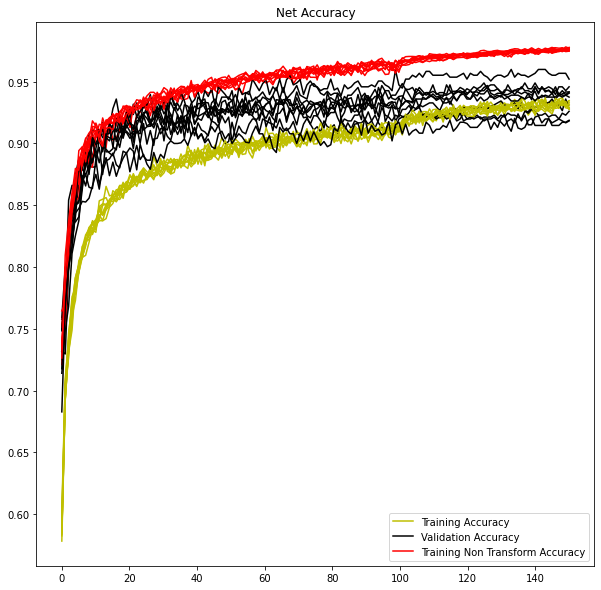

In [0]:
plt.figure(figsize = (10,10))
for i in range(numNets):
    train_x = np.linspace(0, num_epochs, len(training_acc_logger[i]))
    plt.plot(train_x, training_acc_logger[i], c = "y")
    valid_x = np.linspace(0, num_epochs, len(validation_acc_logger[i]))
    plt.plot(valid_x, validation_acc_logger[i], c = "k")
    train_non_transform_x = np.linspace(0, num_epochs, len(training_non_transform_acc_logger[i]))
    plt.plot(train_non_transform_x, training_non_transform_acc_logger[i], c = "r");

plt.title("Net Accuracy")
plt.legend(["Training Accuracy", "Validation Accuracy", "Training Non Transform Accuracy"])

In [0]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True, figsize=(18,12)):

    

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

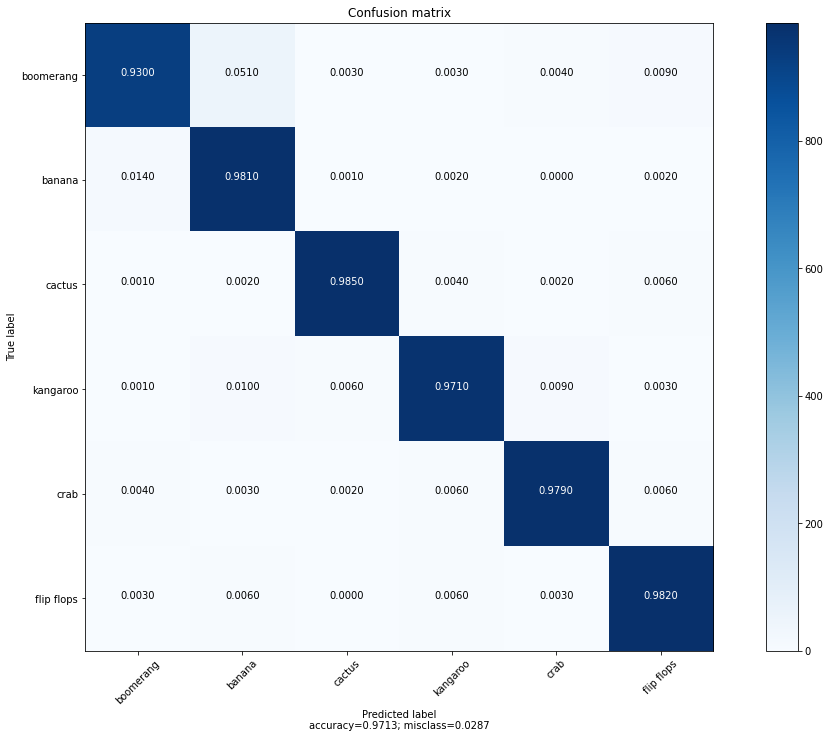

In [0]:
predictionsOneHot = net(torch.tensor(sketchesTrain.reshape(-1, 1, 28, 28)/255,dtype=torch.float32).to(device)).squeeze()
predictions = torch.argmax(predictionsOneHot,axis=1) 

labelNames = ["boomerang","banana","cactus","kangaroo","crab","flip flops"]

cm = confusion_matrix(labels, predictions.cpu())
plot_confusion_matrix(cm, labelNames, figsize = (15,10))

In [0]:
sketchesTestDf = pd.read_csv("sketches_test.csv")
sketchesTest = sketchesTestDf.drop(["word","id",sketchesTestDf.columns[0]], axis = 1).to_numpy()

sketchesTest = sketchesTest.reshape(-1, 1, 28, 28)/255

sketchesTest = torch.tensor(sketchesTest, dtype=torch.float32).to(device)

In [0]:
fx = torch.zeros((1200,6))
with torch.no_grad():
    for net in nets:
        net.cuda()
        net.eval()
        netPredictions = net(sketchesTest).cpu()
        fx += netPredictions
        torch.cuda.empty_cache()

predictions = fx.max(dim=1).indices.cpu()
scores = torch.exp(fx.max(dim=1).values/numNets).cpu()

IndextoLabel = ["boomerang", "banana","cactus","kangaroo","crab","flip flops"]
predictionNames = [IndextoLabel[i] for i in predictions]

In [0]:
worstPredictionsIdx = [i for i in range(len(scores)) if scores[i] < 0.75]
len(worstPredictionsIdx)

100

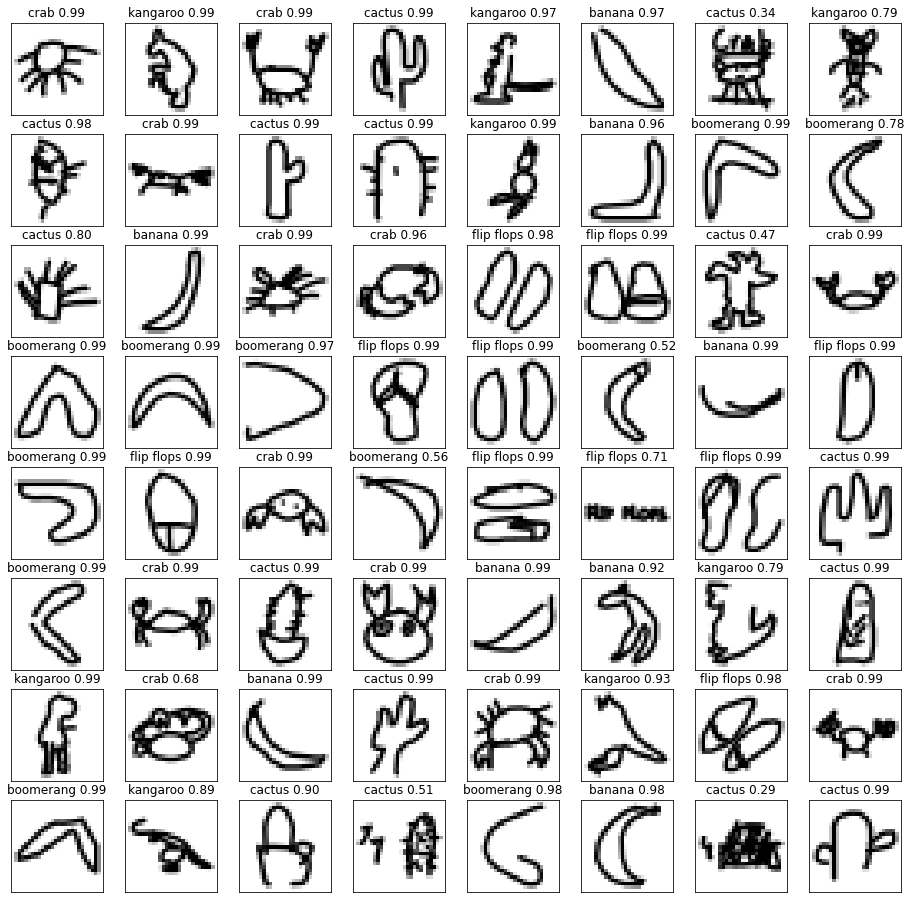

In [0]:
plt.figure(figsize = (16, 16))

for i, image in enumerate(sketchesTest[:64]):    
    plt.subplot(8,8,i+1)
    plt.title(predictionNames[i] + " " + str(scores[i].item())[:4]) 
    plt.imshow(image.squeeze(0).cpu(), cmap='gray_r', vmin=0, vmax=1)
    ax = plt.gca()
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)

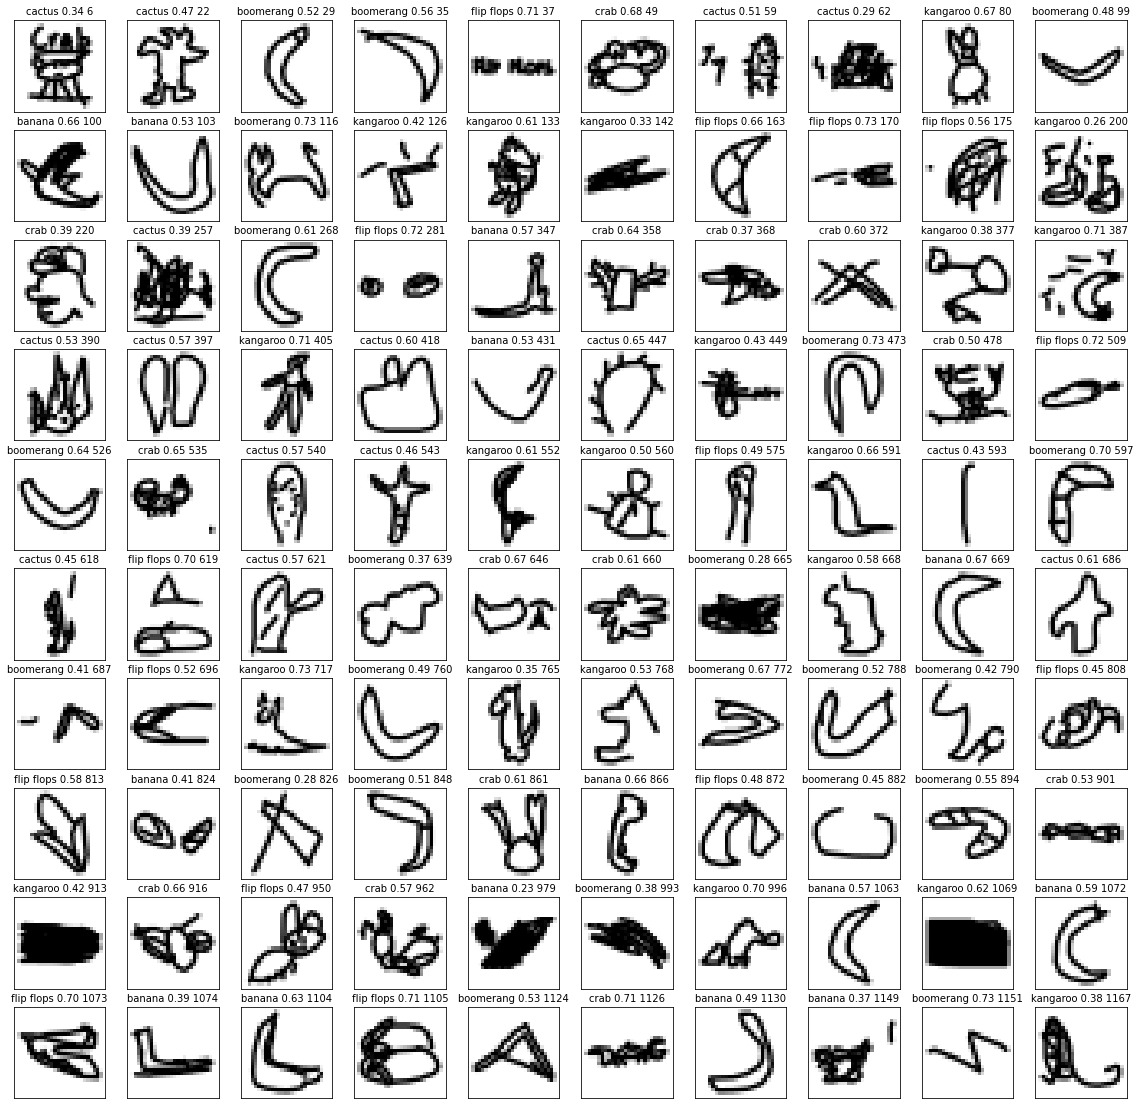

In [0]:
plt.figure(figsize = (20, 40))

for i, predIdx in enumerate(worstPredictionsIdx):
    image = sketchesTest[predIdx]    
    plt.subplot(20,10,i+1)
    plt.title(predictionNames[predIdx] + " " + str(scores[predIdx].item())[:4] + " " + str(predIdx), fontsize=10)
    plt.imshow(image.squeeze(0).cpu(), cmap='gray_r', vmin=0, vmax=1)
    ax = plt.gca()
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)

In [0]:
predictionDf = pd.DataFrame({"id": list(range(1, 1201)), "Category": predictionNames})
predictionDf.to_csv("predictions.csv", index=False)

http://amsantac.co/blog/en/2016/09/20/balanced-image-classification-r.html